In [2]:
import numpy as np
import pandas as pd
import pyspark as ps
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
ratings = pd.read_csv('cleaned_data/ratings.csv')

In [292]:
ratings.head()

,user,movie,rating
0,6040,858,4
1,6040,593,5
2,6040,2384,4
3,6040,1961,4
4,6040,2019,5


In [301]:
ratings[(ratings['user']==3504) & (ratings['movie']==3264)]

,user,movie,rating


In [179]:
ratings.describe()

,user,movie,rating
count,800000.000000,800000.000000,800000.000000
mean,3403.097837,1849.257256,3.590479
std,1546.589028,1086.852485,1.120376
min,636.000000,1.000000,1.000000
25%,2035.000000,1028.000000,3.000000
50%,3507.000000,1788.000000,4.000000
75%,4695.000000,2750.000000,4.000000
max,6040.000000,3952.000000,5.000000


In [194]:
mean = ratings['rating'].mean()

In [391]:
mean

3.59047875

In [172]:
ratings.loc[ratings['user']==6040]

,user,movie,rating
0,6040,858,4
1,6040,593,5
2,6040,2384,4
3,6040,1961,4
4,6040,2019,5
...,...,...,...
211467,6040,535,4
211468,6040,3751,4
211469,6040,495,2
211470,6040,1077,5


In [4]:
ratings.head()

,user,movie,rating
0,6040,858,4
1,6040,593,5
2,6040,2384,4
3,6040,1961,4
4,6040,2019,5


In [5]:
spark = SparkSession.builder.getOrCreate()
spark_df = spark.createDataFrame(ratings)

In [6]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=1)

In [152]:
train.distinct().count()

640665

In [122]:
from pyspark.ml.recommendation import ALS
als_model = ALS(
    itemCol='movie',
    userCol='user',
    ratingCol='rating',
    nonnegative=True,    
    regParam=0.1,
    rank=10)

In [181]:
recommender = als_model.fit(spark_df)

In [182]:
p_ratings = recommender.transform(spark_df)

In [183]:
p_ratings_df = p_ratings.toPandas()

In [184]:
p_ratings_df['squared_error'] = (p_ratings_df['rating'] - p_ratings_df['prediction'])**2

In [127]:
np.sqrt(p_ratings_df['squared_error'].mean())

0.8197275892046302

In [185]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

In [186]:
rmse = evaluator.evaluate(p_ratings)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.8308058452670228


In [16]:
p_ratings.show(10)

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
| 673|  148|     5| 3.8626866|
|4784|  148|     3|  2.840065|
|2383|  148|     2|   2.39018|
|1242|  148|     3| 3.1492693|
|3539|  148|     3|  2.792273|
|1605|  148|     2| 2.0399823|
|1150|  148|     2| 2.4502244|
|3829|  148|     2| 2.0268416|
|2456|  148|     2| 2.4977765|
|2507|  148|     4| 3.1705122|
+----+-----+------+----------+
only showing top 10 rows



In [209]:
itemfactors = recommender.itemFactors
userfactors = recommender.userFactors

In [18]:
user = userfactors.filter('id = 673').collect()
movie = itemfactors.filter('id = 148').collect()

In [19]:
user_vec = np.array(user[0][1])
item_vec = np.array(movie[0][1])
user_vec.dot(item_vec)

3.8626866392605264

In [130]:
prediction = recommender.transform(test)

In [21]:
prediction.show(10)

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
|4227|  148|     2| 1.5799897|
|3184|  148|     4| 2.8290672|
|1069|  148|     2| 2.6959114|
|4858|  463|     3| 2.5466502|
|4040|  463|     1|  1.796684|
|3753|  463|     2|  2.626993|
|3808|  463|     3|  2.378176|
|3829|  463|     2|   1.90345|
|5614|  471|     5| 3.7531898|
|1699|  471|     5| 3.9752107|
+----+-----+------+----------+
only showing top 10 rows



In [23]:
prediction.describe().show()

+-------+------------------+------------------+------------------+----------+
|summary|              user|             movie|            rating|prediction|
+-------+------------------+------------------+------------------+----------+
|  count|            159335|            159335|            159335|    159335|
|   mean| 3404.643781968808|1850.0459032855306|3.5894436250666835|       NaN|
| stddev|1544.5439619295785| 1086.547829296142|1.1216084316255814|       NaN|
|    min|               636|                 1|                 1| 0.5218163|
|    max|              6040|              3952|                 5|       NaN|
+-------+------------------+------------------+------------------+----------+



In [131]:
predictions_df = prediction.toPandas()

In [132]:
predictions_df.head()

,user,movie,rating,prediction
0,4227,148,2,1.919962
1,3184,148,4,3.035991
2,1069,148,2,2.561747
3,4858,463,3,2.481914
4,4040,463,1,1.765732


In [133]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

In [29]:
predictions_df.head()

,user,movie,rating,prediction,squared_error
0,4227,148,2,1.579990,0.176409
1,3184,148,4,2.829067,1.371083
2,1069,148,2,2.695911,0.484293
3,4858,463,3,2.546650,0.205526
4,4040,463,1,1.796684,0.634705


In [134]:
np.sqrt(predictions_df['squared_error'].mean())

0.8760740296097116

In [136]:
rmse = evaluator.evaluate(prediction)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = nan


In [106]:
fake_test = pd.read_csv('data/fake_testing.csv', names=['user', 'movie', 'rating'])

In [107]:
spark_ftest = spark.createDataFrame(fake_test)

ft_transform = recommender.transform(spark_ftest)

In [120]:
ft_transform.show(50)

+----+-----+------------+----------+
|user|movie|actualrating|prediction|
+----+-----+------------+----------+
|  53|  148|           2|       NaN|
|4169|  148|           4| 3.0454652|
|5333|  148|           1| 2.2217238|
|4387|  148|           1| 2.0919197|
| 840|  148|           1| 2.8395712|
| 216|  148|           3|       NaN|
| 482|  148|           2|       NaN|
| 752|  148|           1| 2.9017036|
| 424|  148|           4|       NaN|
| 970|  463|           1| 2.8145456|
|4169|  463|           4| 2.3917847|
|  26|  463|           3|       NaN|
| 319|  463|           1|       NaN|
| 202|  463|           1|       NaN|
| 721|  463|           2| 3.2837703|
| 331|  463|           2|       NaN|
| 524|  463|           2|       NaN|
|1962|  463|           3| 2.0038242|
| 934|  463|           3| 2.2288504|
|1088|  471|           1| 3.3729396|
| 392|  471|           1|       NaN|
| 516|  471|           3|       NaN|
|1265|  471|           4|       NaN|
|4186|  471|           4| 2.8751643|
|

In [113]:
ft_transform_df = ft_transform.toPandas()

In [118]:
len(ft_transform_df)

200209

In [137]:
(ft_transform_df.isna()).sum()

user                0
movie               0
actualrating        0
prediction      95790
dtype: int64

In [145]:
ft_nan_users = ft_transform_df[['user','prediction']]

,user,prediction
0,53,NaN
5,216,NaN
6,482,NaN
8,424,NaN
11,26,NaN
...,...,...
200192,151,NaN
200195,454,NaN
200197,131,NaN
200198,149,NaN


In [148]:
ft_nan_users = ft_nan_users[ft_nan_users['prediction'].isna()]

In [178]:
ft_nan_users.to_csv('cleaned_data/nan_users.csv')

In [119]:
ft_transform_df.head(50)

,user,movie,actualrating,prediction
0,53,148,2,NaN
1,4169,148,4,3.045465
2,5333,148,1,2.221724
3,4387,148,1,2.091920
4,840,148,1,2.839571
5,216,148,3,NaN
6,482,148,2,NaN
7,752,148,1,2.901704
8,424,148,4,NaN
9,970,463,1,2.814546


In [160]:
fake_test2 = pd.read_csv('data/fake_testing.csv')

In [162]:
fake_test2['rating'] = fake_test2['actualrating']

In [163]:
fake_test2.drop(labels='actualrating', axis=1, inplace=True)


In [164]:
spark_ftest2 = spark.createDataFrame(fake_test2)

ft_transform2 = recommender.transform(spark_ftest2)

In [165]:
ft_transform2.show(10)

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
|  53|  148|     2|       NaN|
|4169|  148|     4| 3.0454652|
|5333|  148|     1| 2.2217238|
|4387|  148|     1| 2.0919197|
| 840|  148|     1| 2.8395712|
| 216|  148|     3|       NaN|
| 482|  148|     2|       NaN|
| 752|  148|     1| 2.9017036|
| 424|  148|     4|       NaN|
| 970|  463|     1| 2.8145456|
+----+-----+------+----------+
only showing top 10 rows



In [187]:
test = pd.read_csv('data/requests.csv', header='infer')

,user,movie
0,4958,1924
1,4958,3264
2,4958,2634
3,4958,1407
4,4958,2399


In [189]:
spark_test = spark.createDataFrame(test)
t_transform = recommender.transform(spark_test)

In [214]:
t_transform_df = t_transform.toPandas()

In [215]:
t_transform_df.head()

,user,movie,prediction
0,53,148,NaN
1,4169,148,3.049647
2,5333,148,2.599816
3,4387,148,2.161370
4,840,148,2.586383


In [216]:
mean_df_pred = t_transform_df['prediction'].fillna(mean)

In [217]:
t_transform_df['rating'] = mean_df_pred

In [218]:
request = t_transform_df.drop(labels='prediction', axis=1)

In [219]:
request.head()

,user,movie,rating
0,53,148,3.590479
1,4169,148,3.049647
2,5333,148,2.599816
3,4387,148,2.161370
4,840,148,2.586383


In [222]:
request.to_csv('a_mean_prediction.csv')

In [114]:
# rmse = evaluator.evaluate(ft_transform)
# print("Root-mean-square error = " + str(rmse))

## Plotting

/opt/conda/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


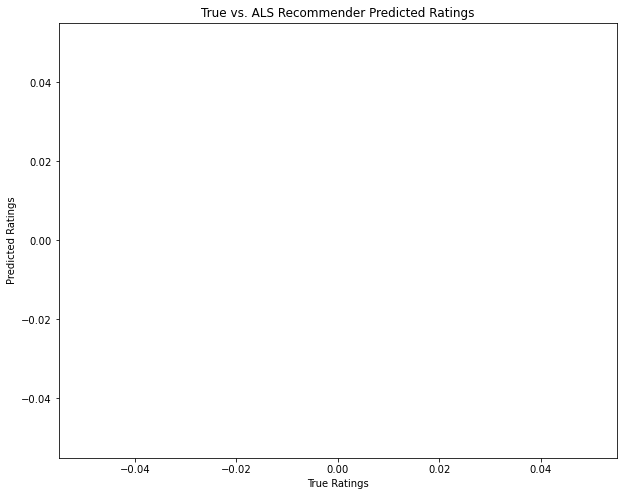

In [138]:
data = [predictions_df['prediction'][predictions_df['rating'] == rating].values for rating in range(1, 6)]

fig, ax = plt.subplots(figsize=(10,8))

ax.violinplot(data, range(1,6), showmeans=False)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [46]:
len(data)

5

(array([1.08192e+05, 2.67550e+04, 1.19400e+04, 5.65000e+03, 2.89300e+03,
        1.54300e+03, 9.27000e+02, 5.27000e+02, 3.52000e+02, 1.80000e+02,
        1.33000e+02, 8.40000e+01, 5.20000e+01, 2.50000e+01, 1.40000e+01,
        1.20000e+01, 7.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00]),
 array([9.0949470e-13, 7.7161729e-01, 1.5432346e+00, 2.3148518e+00,
        3.0864692e+00, 3.8580863e+00, 4.6297035e+00, 5.4013209e+00,
        6.1729383e+00, 6.9445553e+00, 7.7161727e+00, 8.4877901e+00,
        9.2594070e+00, 1.0031025e+01, 1.0802642e+01, 1.1574259e+01,
        1.2345877e+01, 1.3117494e+01, 1.3889111e+01, 1.4660728e+01,
        1.5432345e+01], dtype=float32),
 <a list of 20 Patch objects>)

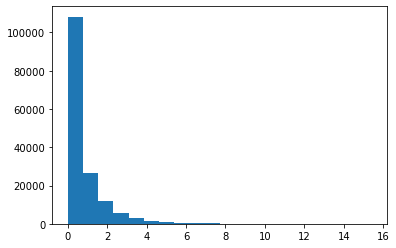

In [53]:
plt.hist(predictions_df['squared_error'], bins=20)

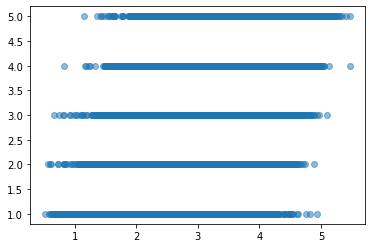

In [52]:
plt.scatter(predictions_df['prediction'],predictions_df['rating'], alpha=.5)

## Understanding Latent Features 

In [210]:
itemfactors_df = itemfactors.toPandas()

In [211]:
(itemfactors_df['features'].values).shape

(3662,)

In [212]:
sorted_items = itemfactors_df.sort_values(by='id')

In [213]:
sorted_items.set_index(keys='id', inplace=True)

In [95]:
sorted_items.values[0][0]

[0.7208385467529297,
 0.08985200524330139,
 0.04785703867673874,
 0.03187407925724983,
 0.7748639583587646,
 0.4837433695793152,
 0.7918107509613037,
 0.9629693627357483,
 0.5698899626731873,
 0.17187771201133728]

In [93]:
matrix = np.zeros([3625,10])

for x in sorted_items.values:
    for i, y in emumerate(x):
        matrix[i,:]

TypeError: data type not understood

In [173]:
sorted_items['features'].values

array([list([0.7208385467529297, 0.08985200524330139, 0.04785703867673874, 0.03187407925724983, 0.7748639583587646, 0.4837433695793152, 0.7918107509613037, 0.9629693627357483, 0.5698899626731873, 0.17187771201133728]),
       list([0.55461585521698, 0.13874153792858124, 0.23370984196662903, 0.21228328347206116, 0.28509384393692017, 0.2697572112083435, 0.24621392786502838, 0.9610529541969299, 0.29356998205184937, 0.5274598002433777]),
       list([0.3442586660385132, 0.29780685901641846, 0.41779056191444397, 0.0, 0.2780248522758484, 0.20978949964046478, 0.44229045510292053, 0.8094544410705566, 0.14861492812633514, 0.8452003598213196]),
       ...,
       list([0.36412936449050903, 0.0, 0.0, 0.27478206157684326, 0.0, 0.35249966382980347, 0.6803697347640991, 1.5678869485855103, 0.32851630449295044, 0.0]),
       list([0.0, 0.5115406513214111, 0.0, 0.08775965869426727, 0.5238903760910034, 0.9095404744148254, 0.5656226873397827, 1.025285005569458, 0.5756511688232422, 0.29113858938217163]),


In [230]:
df1 =pd.DataFrame(sorted_items['features'].values)

In [233]:
df1.head()

,0
0,"[0.6720812916755676, 0.2723863422870636, 0.166..."
1,"[0.7254586815834045, 0.1919596940279007, 0.152..."
2,"[0.5303298830986023, 0.12095838040113449, 0.34..."
3,"[0.3983159065246582, 0.0, 0.05803583934903145,..."
4,"[0.38990771770477295, 0.0, 0.24632224440574646..."


In [234]:
df1[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8', 'Feature9', 'Feature10']] = pd.DataFrame(sorted_items.features.tolist(), index= df1.index)



                                                      0  Feature1  Feature2  \
0     [0.6720812916755676, 0.2723863422870636, 0.166...  0.672081  0.272386   
1     [0.7254586815834045, 0.1919596940279007, 0.152...  0.725459  0.191960   
2     [0.5303298830986023, 0.12095838040113449, 0.34...  0.530330  0.120958   
3     [0.3983159065246582, 0.0, 0.05803583934903145,...  0.398316  0.000000   
4     [0.38990771770477295, 0.0, 0.24632224440574646...  0.389908  0.000000   
...                                                 ...       ...       ...   
3657  [0.4178336560726166, 0.13999389111995697, 0.79...  0.417834  0.139994   
3658  [0.6747111678123474, 0.0, 0.5236049294471741, ...  0.674711  0.000000   
3659  [0.7805098295211792, 0.30106574296951294, 0.0,...  0.780510  0.301066   
3660  [0.07800766080617905, 0.29569533467292786, 0.0...  0.078008  0.295695   
3661  [0.460713654756546, 0.17241594195365906, 0.081...  0.460714  0.172416   

      Feature3  Feature4  Feature5  Feature6  Featu

In [236]:
df1.index +=1

In [271]:
df1['Feature1'].argsort()

1       2476
2       1686
3       1548
4        973
5       1154
        ... 
3658    3622
3659    1950
3660    2337
3661     723
3662    2120
Name: Feature1, Length: 3662, dtype: int64

In [279]:
top_10 = df1.sort_values(by='Feature1', ascending=False).index[:10]

In [280]:
df1.loc[top_10]

,0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10
2121,"[1.790575385093689, 0.11039053648710251, 0.0, ...",1.790575,0.110391,0.000000,0.000000,0.000000,1.278637,0.813312,0.259523,0.000000,0.658201
724,"[1.7874658107757568, 0.0, 0.9788549542427063, ...",1.787466,0.000000,0.978855,0.280445,0.000000,0.098331,0.140312,0.137936,0.556568,0.578793
2338,"[1.7628282308578491, 0.0, 0.0, 0.7756337523460...",1.762828,0.000000,0.000000,0.775634,0.796522,0.636311,0.000000,0.355859,0.000000,0.000000
1951,"[1.7401189804077148, 0.0, 1.0210591554641724, ...",1.740119,0.000000,1.021059,0.000000,0.366988,0.461108,0.586692,0.615171,0.000000,0.000000
3623,"[1.5514417886734009, 0.0, 0.0, 0.6043642163276...",1.551442,0.000000,0.000000,0.604364,1.031249,0.131122,0.556808,0.000000,0.022729,0.229132
2565,"[1.537492036819458, 0.0, 0.11375177651643753, ...",1.537492,0.000000,0.113752,0.000000,1.030595,0.000000,0.123371,0.000000,0.238502,0.000000
2542,"[1.510466456413269, 0.0, 0.4048042893409729, 0...",1.510466,0.000000,0.404804,0.000000,0.075959,0.000000,0.000000,0.000000,0.000000,1.100335
1603,"[1.5009914636611938, 0.0, 0.0, 0.4437328577041...",1.500991,0.000000,0.000000,0.443733,0.000000,0.000000,0.000000,0.612878,0.000000,0.319947
2588,"[1.4474740028381348, 0.0, 0.3324131667613983, ...",1.447474,0.000000,0.332413,0.570103,0.000000,0.975198,0.551498,0.031402,0.000000,0.748261
3442,"[1.4005751609802246, 0.3500405251979828, 0.0, ...",1.400575,0.350041,0.000000,0.824454,0.005632,0.270539,1.197853,0.199629,0.192955,0.000000


In [269]:
index_high

3662    2120
3661     723
3660    2337
3659    1950
3658    3622
3657    2564
3656    2541
3655    1602
3654    2587
3653    3441
3652    3613
3651    3492
3650    2529
3649    2674
3648     692
3647    3565
3646    2720
3645    3019
3644    3491
3643    1014
Name: Feature1, dtype: int64

In [267]:
index_high = np.argsort(df1['Feature1'])[:-21:-1]

In [249]:
index2 = np.argsort(df1['Feature2'])[:-21:-1]

In [239]:
movies = pd.read_csv('cleaned_data/movies.csv')

In [281]:
movies.loc[top_10]

,movie_id,movie_title,genre,year
2121,2190,Why Do Fools Fall In Love? (1998),Drama,1998
724,733,"Rock, The (1996)",Action Adventure Thriller,1996
2338,2407,Cocoon (1985),Comedy Sci-Fi,1985
1951,2020,Dangerous Liaisons (1988),Drama Romance,1988
3623,3692,Class of Nuke 'Em High (1986),Comedy Horror,1986
2565,2634,"Mummy, The (1959)",Horror,1959
2542,2611,"Winslow Boy, The (1998)",Drama,1998
1603,1649,"Fast, Cheap & Out of Control (1997)",Documentary,1997
2588,2657,"Rocky Horror Picture Show, The (1975)",Comedy Horror Musical Sci-Fi,1975
3442,3511,Ready to Rumble (2000),Comedy,2000


In [23]:
userfactors_df = userfactors.toPandas()

In [25]:
(userfactors_df['features'].values).


(5399,)

In [30]:
userfactors_df['features'].values[0]

[0.6564563512802124,
 0.682487964630127,
 0.7633579969406128,
 0.6249393820762634,
 0.48795026540756226,
 0.8060238361358643,
 0.9950987100601196,
 1.3105900287628174,
 1.3464887142181396,
 0.7762758731842041]

In [31]:
userfactors_df

,id,features
0,640,"[0.6564563512802124, 0.682487964630127, 0.7633..."
1,650,"[0.7669003009796143, 0.18694300949573517, 0.41..."
2,660,"[0.5475112199783325, 0.7113644480705261, 0.285..."
3,670,"[0.6252161860466003, 0.6471410393714905, 0.211..."
4,680,"[0.7640587687492371, 0.45688655972480774, 0.21..."


In [251]:
sorted_users = userfactors_df.sort_values(by='id')

In [252]:
df_users =pd.DataFrame(sorted_users['features'].values)


In [253]:
df_users[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8', 'Feature9', 'Feature10']] = pd.DataFrame(sorted_users.features.tolist(), index= df_users.index)


In [254]:
df_users.index +=1

In [255]:
df_users.head()

,0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10
1,"[1.2241692543029785, 0.7386487722396851, 0.984...",1.224169,0.738649,0.984296,0.400431,1.338463,0.262793,0.565117,0.978237,1.123354,1.059999
2,"[0.7528027892112732, 0.6417350172996521, 0.228...",0.752803,0.641735,0.228587,0.135319,1.032032,0.924518,0.769973,1.436985,0.618981,0.448797
3,"[1.1774983406066895, 0.65328049659729, 0.41209...",1.177498,0.653280,0.412098,0.186867,0.902422,0.265526,0.971099,1.290294,1.337637,0.625909
4,"[0.5232113003730774, 0.4279670715332031, 0.360...",0.523211,0.427967,0.360116,0.215589,0.946464,0.348920,0.595450,1.516825,0.664664,1.086787
5,"[0.6564563512802124, 0.682487964630127, 0.7633...",0.656456,0.682488,0.763358,0.624939,0.487950,0.806024,0.995099,1.310590,1.346489,0.776276


In [260]:
users = pd.read_csv('cleaned_data/users.csv', index_col='user_id')



In [261]:
users.head()

,gender,age,occ,zipcode,zipclean,occ_name
user_id,,,,,,
1,F,1,10,48067,48067,K-12 student
2,M,56,16,70072,70072,self-employed
3,M,25,15,55117,55117,scientist
4,M,45,7,02460,2460,executive/managerial
5,M,25,20,55455,55455,writer


In [284]:
top_20 = df_users.sort_values(by='Feature1', ascending=False).index[:20]

In [286]:
top_20_two = df_users.sort_values(by='Feature2', ascending=False).index[:20]

In [289]:
top_20_three = df_users.sort_values(by='Feature3', ascending=False).index[:20]

In [290]:
users.loc[top_20_three]

,gender,age,occ,zipcode,zipclean,occ_name
3203,M,35,0,90254,90254,other
4956,M,35,15,77007,77007,scientist
5278,F,25,7,55122,55122,executive/managerial
3274,M,25,20,02062,2062,writer
4458,F,25,4,15701-2017,15701,college/grad student
106,F,35,11,79101,79101,lawyer
3465,M,25,14,45383,45383,sales/marketing
1027,M,18,4,77005,77005,college/grad student
240,M,50,17,55113,55113,technician/engineer
1272,M,18,20,49506,49506,writer


## User Subset

In [52]:
recommender.recommendForItemSubset(train, 10).show()

+-----+--------------------+
|movie|     recommendations|
+-----+--------------------+
|  463|[[3113, 4.609388]...|
| 1591|[[3902, 4.194338]...|
| 3918|[[2867, 4.469325]...|
| 3175|[[3902, 4.89802],...|
|  496|[[932, 4.7633276]...|
| 1238|[[1371, 4.8083806...|
| 3794|[[3545, 4.860028]...|
| 1342|[[2155, 4.607645]...|
|  833|[[3902, 4.076675]...|
| 2366|[[2755, 4.703263]...|
| 1829|[[2694, 3.7814484...|
|  471|[[692, 4.4713182]...|
| 1959|[[4900, 4.6678233...|
| 1580|[[3902, 5.0550857...|
| 2142|[[3902, 4.1652203...|
| 2659|[[3902, 4.536792]...|
| 2866|[[2339, 4.4895797...|
| 1088|[[4778, 4.936863]...|
| 2122|[[2155, 4.9339128...|
| 1645|[[3902, 5.0015507...|
+-----+--------------------+
only showing top 20 rows



In [53]:
recommender.recommendForUserSubset(train, 10).show()

+----+--------------------+
|user|     recommendations|
+----+--------------------+
|4519|[[811, 5.669782],...|
|4935|[[3906, 5.214474]...|
|1591|[[557, 5.9289923]...|
|3918|[[3906, 5.026055]...|
|3175|[[3906, 5.815897]...|
|4900|[[572, 5.9214687]...|
|1238|[[557, 5.2848577]...|
|3794|[[2309, 4.4060407...|
|1342|[[572, 4.5137315]...|
| 833|[[572, 5.4476247]...|
|2366|[[572, 4.6917243]...|
|5803|[[97, 4.5318174],...|
|1829|[[3906, 5.228789]...|
|4101|[[2086, 4.929735]...|
|5518|[[557, 5.3904967]...|
|1959|[[572, 5.5938325]...|
|1580|[[557, 4.591143],...|
|2142|[[572, 4.8600545]...|
|5300|[[3906, 5.5257773...|
|2659|[[3906, 5.4109], ...|
+----+--------------------+
only showing top 20 rows



NameError: name 'l' is not defined

In [313]:
movie_set = set(request['movie'])

In [321]:
len(movie_set)

3511

In [314]:


ratings_set = set(ratings['movie']) 

In [320]:
len(ratings_set)

3662

In [315]:
total = ratings_set & movie_set

In [319]:
ratings.loc[ratings['movie']['total']]

KeyError: 'total'

In [325]:
avg_rating = ratings[['movie','rating']].groupby('movie').mean()

In [342]:
avg_rating.iloc[148]

rating    3.664
Name: 154, dtype: float64

In [329]:
t_transform_df.head(25)

,user,movie,prediction,rating
0,53,148,NaN,3.590479
1,4169,148,3.049647,3.049647
2,5333,148,2.599816,2.599816
3,4387,148,2.161370,2.161370
4,840,148,2.586383,2.586383
5,216,148,NaN,3.590479
6,482,148,NaN,3.590479
7,752,148,2.897602,2.897602
8,424,148,NaN,3.590479
9,970,463,2.745018,2.745018


In [356]:
# t_transform_df['rating2'] = t_transform_df['prediction'].fillna(function)
rating_map = avg_rating.to_dict()

In [363]:
x = t_transform_df[pd.isna(t_transform_df['prediction'])]['movie'].tolist()

In [364]:
x.

[148,
 148,
 148,
 148,
 463,
 463,
 463,
 463,
 463,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 471,
 496,
 833,
 833,
 833,
 833,
 833,
 833,
 833,
 833,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1088,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238,
 1238

In [365]:
t_transform_df.to_csv('results.csv')

In [373]:
p = t_transform_df[['movie','prediction']].set_index(keys=t_transform_df['movie'])

In [376]:
p[prediction].apply(lambda x: x ==fillna(avg_rating.loc[x.index]))

KeyError: DataFrame[user: bigint, movie: bigint, rating: bigint, prediction: float]

In [384]:
p_nan = p['prediction'].isna()

In [385]:
p_nan

movie
148      True
148     False
148     False
148     False
148     False
        ...  
3910    False
3910    False
3910    False
3910    False
3910    False
Name: prediction, Length: 200209, dtype: bool

In [390]:
p_t = (p.nan == True)

AttributeError: 'DataFrame' object has no attribute 'nan'

In [383]:
set(p.index)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 52,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 110,
 111,
 112,
 113,
 114,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 128,
 129,
 131,
 132,
 135,
 136,
 137,
 138,
 140,
 141,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 

KeyboardInterrupt: 

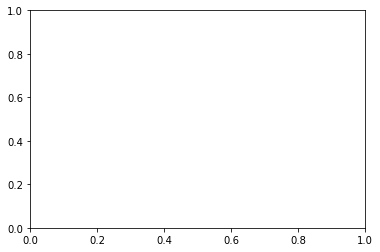

In [393]:
plt.hist(avg_rating, bins=50)

In [394]:
avg_rating.loc[2190]

rating    2.8
Name: 2190, dtype: float64